## Goal of Experiment 1: Set aside a testing set that contains equal amounts of normal and abnormal subset. Use the rest of data for training and use custom loss to scale based on training ratio of normal to abnormal subsets.

In [1]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
import os, sys, time
from math import floor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from collections import OrderedDict
# from tensorflow.python.ops import math_ops
# import tensorflow.keras.backend as kb
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses

# Custom Functions
# Added to path by using sys.path.append('')
sys.path.append('/home/akanu/git/anomalous_pred/custom_functions')
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from custom_metrics import bb_intersection_over_union, bb_intersection_over_union_np
from coordinate_change import xywh_tlbr, tlbr_xywh
from pedsort import pedsort

# Kmeans
from sklearn.cluster import KMeans

# Need to figue out why this is not working
# from persistence1d import RunPersistence


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
plt.style.use('classic')

# GPU check

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


# Load Data

In [6]:
frames = 20

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

# Don't forget to change to xywh 
traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre', to_xywh=True)
testdict = Boxes(loc_files_test, box_test_txt, frames, pad ='pre', to_xywh = True)
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict) #splits by which predicted frames are normal or not

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.3)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Load or Train Model

In [8]:
sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
from lstm_models import lstm_xywh_avenue_20

In [9]:
model_loc = '/home/akanu/git/anomalous_pred/saved_models'
nc=['lstm', 'xywh', 'avenue', frames]

In [10]:
loaded_model = os.path.join(model_loc,
                            '{}_{}_{}_{}.h5'.format(nc[0], nc[1],nc[2], nc[3]))
lstm_20 = tf.keras.models.load_model(loaded_model,  
                                   custom_objects = {'loss':'mse'} , 
                                   compile=True)


# Load Data for Binary Network

In [11]:
def return_indices(data, abnormal_split = 0.5):
    """
    Note that function returns index values that will
    allow for the creation of a test set that has an equal amount of normal
    and abnormal examples. Rest of abnormal and normal are then used 
    in the training set.
    
    data: 1 and 0's whose location in index corresponds to location 
            in acutal dataset
    abnormal_split: percentage of abnormal frames to put in test frame
    
    returns: list that contains indices 
            [train_abn_indices, train_n_indices, test_abn_indices, test_n_indices]
    """
    

    abnorm_index = np.where(data == 1)
    norm_index = np.where(data == 0)
    
    rand_an = np.random.permutation(len(abnorm_index[0]))
    rand_n = np.random.permutation(len(norm_index[0]))
    # Permutates the found abnormal and normal indices
    abnorm_index = abnorm_index[0][rand_an]
    norm_index = norm_index[0][rand_n]
    
    
    len_abn_split = floor(len(abnorm_index)*abnormal_split)
    
    # Testing set indices
    test_abn_indices = abnorm_index[:len_abn_split]
    test_n_indices = norm_index[:len_abn_split]
        
    train_abn_indices = abnorm_index[len_abn_split:]
    train_n_indices = norm_index[len_abn_split:]
    
    return [train_abn_indices, train_n_indices, test_abn_indices, test_n_indices]

   

# Checking index values are correct
# 1) Size
# 2) Correct Selection

In [12]:

indices = return_indices(testdict['abnormal'], abnormal_split = 0.5)


In [13]:
print('These are index\n' + 
       'train_abn:{},train_n: {},test_abn: {},test_n {}'.format(indices[0].shape,
                                                                indices[1].shape,
                                                                indices[2].shape,
                                                                indices[3].shape,))

These are index
train_abn:(1465,),train_n: (111229,),test_abn: (1465,),test_n (1465,)


# 2) Correct Selection

In [14]:
print('Are abnormal values for train and test respectively correct? \n' +
     '{} and {}'.format(np.all(testdict['abnormal'][indices[0]] == 1),
                        np.all(testdict['abnormal'][indices[2]] ==1)
                       )
     )

Are abnormal values for train and test respectively correct? 
True and True


In [15]:
print('Are normal values for train and test respectively correct? \n' +
     '{} and {}'.format(np.all(testdict['abnormal'][indices[1]] == 0),
                        np.all(testdict['abnormal'][indices[3]] ==0)
                       )
     )

Are normal values for train and test respectively correct? 
True and True


In [16]:
x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
print('x has a shape of : {}\n'.format(x.shape) +
      'y has a shape of : {}'.format(y.shape))

x has a shape of : (115624, 20, 4)
y has a shape of : (115624, 4)


COuld probably make binary data split easier for adding more features
by performing data auc outside and inputing that into function. Might look into as well to make code more maintainable. Could allow me to call the function in some ratio split train val function.

In [17]:
def binary_data_split(x,y, model, indices):
    """
    x: normed testing data
    y: normed tested data 
    indices: [train_abn_indices, train_n_indices, test_abn_indices, test_n_indices]
    
    return: train_x, train_y, test_x, test_y
            Note that the second coloumn of train_x and test_x
            contain the indices corresponding the location in unshuffled
            dictornary
    """
    
    out1 = model.predict(x)
    out = bb_intersection_over_union_np(xywh_tlbr(out1),xywh_tlbr(y))
    out = np.squeeze(out)
    
    train_x = np.array( [np.append(out[indices[0]], out[indices[1]] ),
                        np.append(indices[0], indices[1])])

    train_y = np.append(np.ones(len(indices[0])),
                  np.zeros(len(indices[1])) )


    test_x = np.array( [np.append(out[indices[2]], out[indices[3]] ),
                        np.append(indices[2], indices[3])])
    test_y = np.append(np.ones(len(indices[2])),
                      np.zeros(len(indices[3])) )
    
    return train_x,train_y, test_x, test_y

    
    

In [18]:
train_full_x,train_full_y, test_x, test_y = binary_data_split(x,y,lstm_20, indices)

In [19]:
print('Comparing shape length of train_full_x and test_x \n' +
     'train_full_x: {}, test_x:{}'.format(train_full_x.shape,
                                         test_x.shape))

Comparing shape length of train_full_x and test_x 
train_full_x: (2, 112694), test_x:(2, 2930)


In [20]:
def same_ratio_split_train_val(train_x,train_y, val_ratio = 0.3):
    """
    train_x: training x data for binary classifer. shape (2, somenumber)
    train_y: training y data for binary classifer. shape (somenumber,) 
    val_ratio: ratio to split between validation and training set
    
    return: val_x, val_y, train_x, train_y
    """
    
    abnorm_index = np.where(train_y == 1)
    norm_index = np.where(train_y == 0)
    rand_an = np.random.permutation(len(abnorm_index[0]))
    rand_n = np.random.permutation(len(norm_index[0]))
    abnorm_index = abnorm_index[0][rand_an]
    norm_index = norm_index[0][rand_n]
    
    len_val_ab = int(len(abnorm_index)*val_ratio)
    len_val_n = int(len(norm_index)*val_ratio)

    
    val_x = np.append(train_x[:,abnorm_index[:len_val_ab]] ,
                      train_x[:,norm_index[:len_val_n]], axis = 1)
    
#     part1 = train_x[:,abnorm_index[:len_val_ab]]
#     part2 = train_x[:,norm_index[:len_val_n]]
#     print('This is shape of part 1 of append: {}'.format(part1.shape))
#     print('This is shape of part 2 of append: {}'.format(part2.shape))
#     print('This is the combined shape of part 1 and 2 {}'.format(val_x.shape))
    
    val_y = np.append(train_y[abnorm_index[:len_val_ab]], 
                      train_y[norm_index[:len_val_n]])
    
    train_x = np.append(train_x[:,abnorm_index[len_val_ab:]] ,
                      train_x[:,norm_index[len_val_n:]], axis=1)
    
    train_y = np.append(train_y[abnorm_index[len_val_ab:]], 
                      train_y[norm_index[len_val_n:]])
    
    
    return val_x, val_y, train_x, train_y    

In [21]:
# indices = return_indices(testdict['abnormal'], abnormal_split = 0.5)
# x,y = norm_train_max_min(data_dict=testdict, max1 = max1, min1=min1 )
# train_full_x,train_full_y, test_x, test_y = binary_data_split(x,y,lstm_20, indices)

In [22]:
val_x, val_y, train_x, train_y = same_ratio_split_train_val(train_full_x,train_full_y, val_ratio = 0.3)
weight_ratio = len(indices[0])/len(indices[1])


In [23]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
# Note that I need to index into correct column as one is IOU
# and last column is index values to map back into datadicg
train_bm = tf.data.Dataset.from_tensor_slices((train_x[0,:],train_y))
train_bm = train_bm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_bm = tf.data.Dataset.from_tensor_slices((val_x[0,:],val_y))
val_bm = val_bm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Weighted Loss

In [24]:
# weight ratio for inital bias and ratio for weighted binary
# might be different thats why error could be occuring
# initial_bias = np.log([pos/neg])
initial_bias = np.log([weight_ratio]) # want to take out of here
initial_bias
# Note that value is negative now

array([-4.3297359])

In [25]:
1/weight_ratio

75.92423208191127

In [26]:
'{:.3f}'.format(1/weight_ratio)

'75.924'

In [27]:
weight_ratio

0.013171025541900043

labels * -log(sigmoid(logits)) * pos_weight +
    (1 - labels) * -log(1 - sigmoid(logits)) 
    
This means that the into must be 1/weight ratio. Assuming
weight_ratio = pos/neg
    

In [28]:
def weighted_binary(y,x):
    return tf.nn.weighted_cross_entropy_with_logits(y,x,pos_weight = 1/weight_ratio)

In [29]:
sys.path.insert(0,'/home/akanu/git/anomalous_pred/model')
from binary_classification import Dense_5_Drop_2

In [30]:
temp = os.path.join(model_loc, 'Experiment_1')

In [31]:
nc_bin = ['Dense_5_Drop_5', 'xywh','avenue', frames, 0.500]

In [39]:
# binary_model = create_baseline_weighted(initial_bias)
bm_history,bm_model = Dense_5_Drop_2(train_bm,
                              val_bm,
                              os.path.join(model_loc, 'Experiment_1'),
                              nc_bin,
                              weighted_binary,
                              initial_bias,
                              300
                             )


Epoch 1/300
2466/2466 [==============================] - 13s 5ms/step - loss: 4.3314 - accuracy: 0.9870 - val_loss: 4.2972 - val_accuracy: 0.9870
Epoch 2/300
2466/2466 [==============================] - 13s 5ms/step - loss: 4.2688 - accuracy: 0.9870 - val_loss: 4.2280 - val_accuracy: 0.9870
Epoch 3/300
2466/2466 [==============================] - 13s 5ms/step - loss: 4.1925 - accuracy: 0.9870 - val_loss: 4.1387 - val_accuracy: 0.9870
Epoch 4/300
2466/2466 [==============================] - 13s 5ms/step - loss: 4.0841 - accuracy: 0.9870 - val_loss: 4.0146 - val_accuracy: 0.9870
Epoch 5/300
2466/2466 [==============================] - 13s 5ms/step - loss: 3.9365 - accuracy: 0.9870 - val_loss: 3.8369 - val_accuracy: 0.9870
Epoch 6/300
2466/2466 [==============================] - 13s 5ms/step - loss: 3.7148 - accuracy: 0.9870 - val_loss: 3.6052 - val_accuracy: 0.9870
Epoch 7/300
2466/2466 [==============================] - 13s 5ms/step - loss: 3.4678 - accuracy: 0.9870 - val_loss: 3.3257 -

Epoch 57/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.3113 - accuracy: 0.8763 - val_loss: 1.3480 - val_accuracy: 0.9870
Epoch 58/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.2955 - accuracy: 0.8752 - val_loss: 1.3326 - val_accuracy: 0.9777
Epoch 59/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.3105 - accuracy: 0.8728 - val_loss: 1.3190 - val_accuracy: 0.9761
Epoch 60/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.2733 - accuracy: 0.8751 - val_loss: 1.3037 - val_accuracy: 0.9740
Epoch 61/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.2485 - accuracy: 0.8747 - val_loss: 1.2973 - val_accuracy: 0.9725
Epoch 62/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.2153 - accuracy: 0.8749 - val_loss: 1.2933 - val_accuracy: 0.9705
Epoch 63/300
2466/2466 [==============================] - 13s 5ms/step - loss: 1.2130 - accuracy: 0.8718 - val_loss: 1

In [60]:
plot_loc = '/home/akanu/git/anomalous_pred/plots/experiment_1/Avenue'


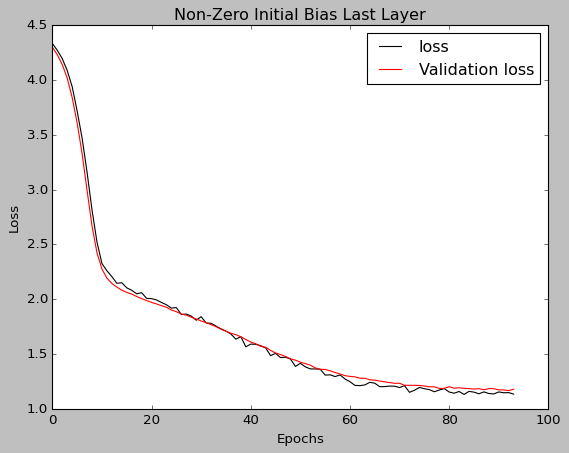

In [61]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history.history['loss'], '-', color='black',label='loss')
ax.plot(bm_history.history['val_loss'],'-',color='red' ,label ='Validation loss')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Non-Zero Initial Bias Last Layer')
fig.savefig(os.path.join(plot_loc, 'loss_{}_{}_{}_{}_{}.jpg'.format(nc_bin[0],
                                                                    nc_bin[1],
                                                                    nc_bin[2],
                                                                    nc_bin[3],
                                                                    nc_bin[4])))

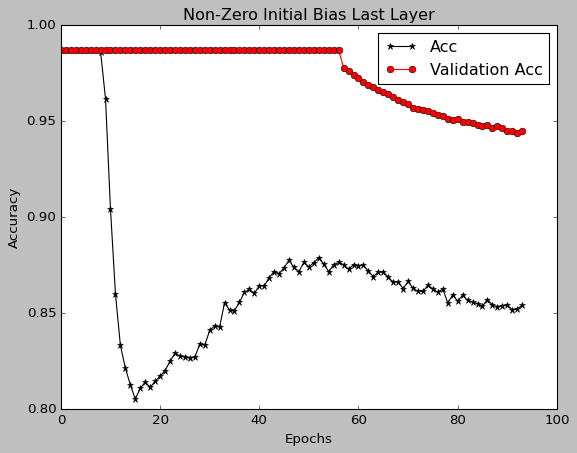

In [62]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.plot(bm_history.history['accuracy'], '-*', color='black',label='Acc')
ax.plot(bm_history.history['val_accuracy'],'-o', color='red', label ='Validation Acc')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Non-Zero Initial Bias Last Layer')
fig.savefig(os.path.join(plot_loc, 'acc_{}_{}_{}_{}_{}.jpg'.format(nc_bin[0],
                                                                    nc_bin[1],
                                                                    nc_bin[2],
                                                                    nc_bin[3],
                                                                    nc_bin[4])))

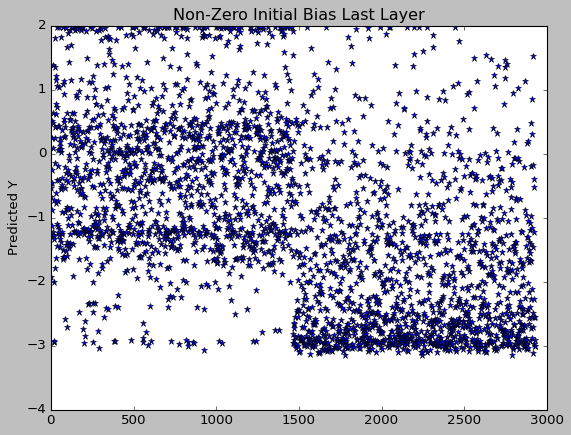

In [63]:
fig,ax = plt.subplots(1,1)
ax.plot(bm_model.predict(test_x[0,:]), '*')
plt.title('Non-Zero Initial Bias Last Layer')
plt.ylabel('Predicted Y')
fig.savefig(os.path.join(plot_loc, 'scatter_{}_{}_{}_{}_{}.jpg'.format(nc_bin[0],
                                                                    nc_bin[1],
                                                                    nc_bin[2],
                                                                    nc_bin[3],
                                                                    nc_bin[4])))

In [37]:
y_pred = bm_model.predict(test_x[0,:])

In [ ]:
plt.plot(y_pred, '*')

In [38]:
y_pred = bm_model.predict(test_x[0,:]) >-1.5
tf.math.confusion_matrix(test_y, y_pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1465,    0],
       [1465,    0]], dtype=int32)>